# Regression Demo Model Runbook

<img src="forecasting.jpg" alt="forecasting" width="800"/>

## Context
The problem is borrowed from Kaggle competitions "https://www.kaggle.com/kannanaikkal/food-demand-forecasting". 
The task is to forecast the number of orders for different meal items at different fulfillment centers for a meal delivery company that operates in multiple cities.
145 weeks worth of sale data is provided for different centers and the client needs help with demand forecasting at these centers for upcoming weeks so that these centers will plan the stock of perishable raw materials accordingly. In addition to the sales data, client has also provided some meta data on its meal items (e.g. meal category and type of cuisine) and the fulfillment center (e.g. operating area and type of center).
Since the labels for test data are not available, we only use train data set in this demo exercise and hold out some proportion for evaluation.  
The forecasting would help in improving business growth and planning staffing schedules.

In [14]:
# load td and non-td libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor)
from xgboost import XGBRegressor
import sklearn.metrics as skm

In [15]:
#teradata ML Libraries
from teradataml import DataFrame , create_context, copy_to_sql
import getpass

## 1. Establish connection to AOPS Vantage instance

In [3]:
#connection context; tdprd3 is used because it has the latest TD Database 
#and also the VAL installed under TRNG_XSP 
host = '3.238.151.85'
username = 'AOA_DEMO' #update username as needed
password = getpass.getpass() #FppT4qdna7
#logmech = 'LDAP'
database_name = 'AOA_DEMO'

 ·········


In [4]:
# create the connection using credentials
try: 
    eng=create_context(host=host, username=username, password=password)#, logmech=logmech)
    conn=eng.connect()
except Exception as err:
    print(err)  

[Teradata][teradataml](TDML_2000) Failed to connect to Teradata Vantage.


## 2. Upload raw data to AOPS Vantage instance for demo

This is not part of the demo. In a real case, we can assume that the data already resides in Teradata (Vantage) or will be loaded through other data pipelines. For this demo we manually load the data into Vantage to be used in AOPS UI/workflow.

In [16]:
#load data from csvs
wd = (r'C:\Users\KS250117\Desktop\Work\Training\AnalyticsOps\Demo Models Work'
      r'\Datasets\Kaggle_food demand forecasting')
train_df = pd.read_csv(wd+r'\train.csv')
#test_df = pd.read_csv(wd+r'\test.csv')
meal_info = pd.read_csv(wd+r'\meal_info.csv')
center_info = pd.read_csv(wd+r'\fulfilment_center_info.csv')

train_df.set_index('id', inplace=True)

In [ ]:
#upload to AOPS Vantage instance
try:
    copy_to_sql(train_df, table_name='demand_forecast_demo_train_raw', schema_name='AOA_DEMO', if_exists='replace')
    copy_to_sql(meal_info, table_name='demand_forecast_demo_meal', schema_name='AOA_DEMO', if_exists='replace')
    copy_to_sql(center_info, table_name='demand_forecast_demo_center', schema_name='AOA_DEMO', if_exists='replace')
except:
    print(err)

In [6]:
#read back data into TD DataFrames
try:
    train_td_df = DataFrame('demand_forecast_demo_train_raw')
    meal_info_td = DataFrame('demand_forecast_demo_meal')
    center_info_td = DataFrame('demand_forecast_demo_center')
except:
    print(err)
train_td_df.head()

   week  center_id  meal_id  checkout_price  base_price  emailer_for_promotion  homepage_featured  num_orders
0     1         99     1770          340.53      486.03                      0                  0          28
1     1        129     2306          243.50      307.52                      0                  0          26
2     1         86     1558          583.03      618.86                      1                  1         540
3     1         36     2494          243.50      270.63                      0                  0          28
4     1         77     1207          315.28      316.28                      0                  0          95
5     1         66     1885          114.46      116.46                      0                  0         674
6     1         27     1445          628.62      626.62                      0                  0          82
7     1         92     2640          242.53      243.53                      0                  0          14
8     1   

## 3. Considering the data is already in Vantage the data science steps may start from here

### 3.1. Exploratory Data Analysis

In [17]:
df_combined = pd.merge(left=train_df, right=center_info, left_on='center_id',
                    right_on = 'center_id', how='left')
df_combined = pd.merge(left=df_combined, right=meal_info, left_on='meal_id',
                    right_on = 'meal_id', how='left')
if 'id' in df_combined.columns:
    df_combined.set_index('id', inplace=True)
df_combined.columns

Index(['week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine'],
      dtype='object')

In [18]:
feature_names_selected = ['checkout_price', 'base_price',
                 'emailer_for_promotion', 'homepage_featured',
                 'op_area', 'category', 'cuisine']
target_name = 'num_orders'
feature_names_numeric = ['checkout_price', 'base_price', 'op_area']
feature_names_selected_cat = ['center_type', 'category', 'cuisine']
feature_names_cat_all = ['center_id', 'city_code', 'region_code', 'center_type', 'category', 'cuisine']
df_combined[feature_names_cat_all].astype('category')

,center_id,city_code,region_code,center_type,category,cuisine
0,55,647,56,TYPE_C,Beverages,Thai
1,55,647,56,TYPE_C,Beverages,Thai
2,55,647,56,TYPE_C,Beverages,Thai
3,55,647,56,TYPE_C,Beverages,Indian
4,55,647,56,TYPE_C,Beverages,Indian
...,...,...,...,...,...,...
456543,61,473,77,TYPE_A,Desert,Indian
456544,61,473,77,TYPE_A,Desert,Indian
456545,61,473,77,TYPE_A,Salad,Italian
456546,61,473,77,TYPE_A,Salad,Italian


In [25]:
#basic data stats 
df_combined.describe()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000
mean,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760,601.553399,56.614566,4.083590
std,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798,66.195914,17.641306,1.091686
min,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000,456.000000,23.000000,0.900000
25%,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000,553.000000,34.000000,3.600000
50%,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000,596.000000,56.000000,4.000000
75%,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000,651.000000,77.000000,4.500000
max,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000,713.000000,93.000000,7.000000


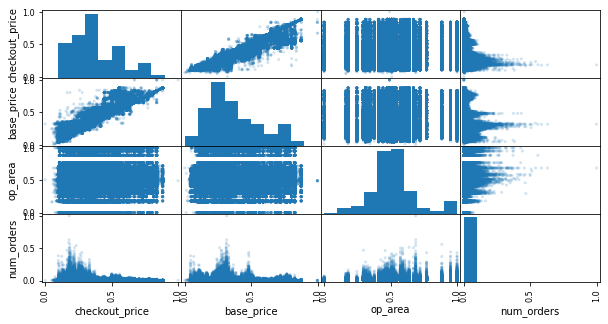

In [29]:
# correlation plots for numeric variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sel_col = feature_names_numeric+[target_name]
df_tf = pd.DataFrame(scaler.fit_transform(df_combined[sel_col].values), columns=sel_col)
plt = pd.plotting.scatter_matrix(df_tf, alpha=0.2, figsize=(10,5))

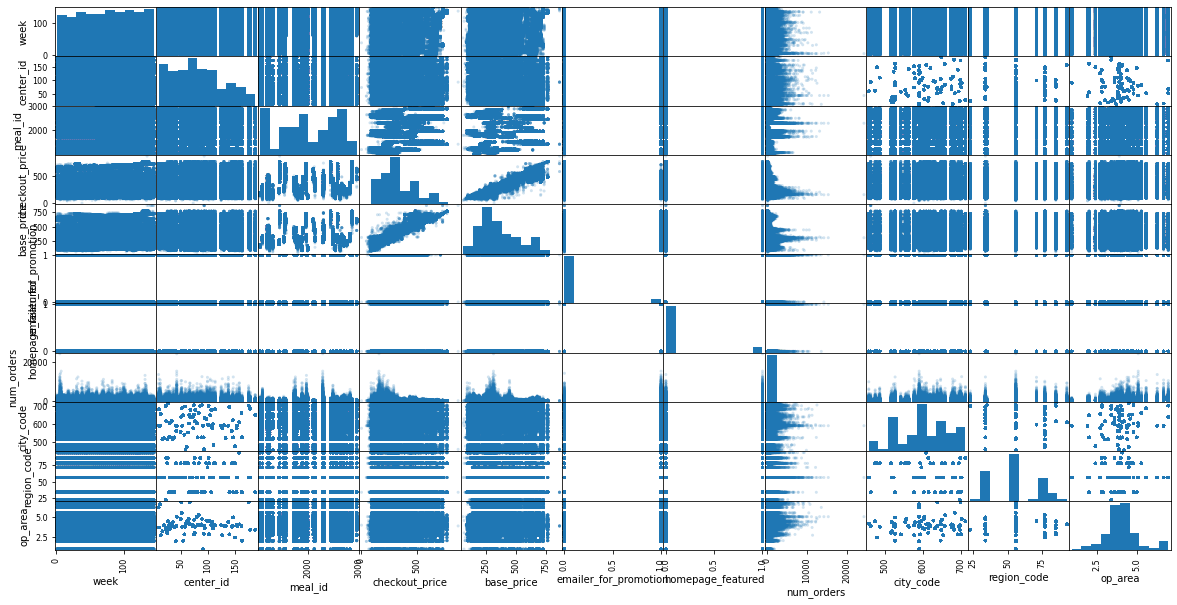

In [31]:
#scatter matrix of all variables without transformation
plt = pd.plotting.scatter_matrix(df_combined, alpha=0.2, figsize=(20,10))

<AxesSubplot:>

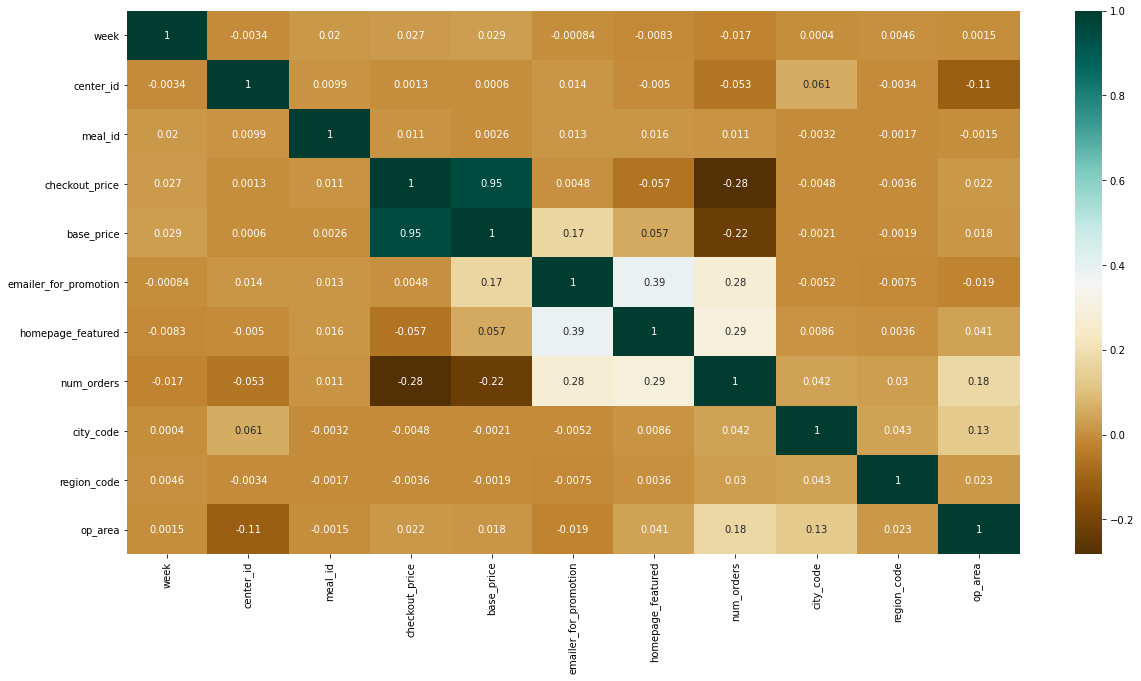

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
c=df_combined.corr()
sns.heatmap(c,cmap="BrBG",annot=True)

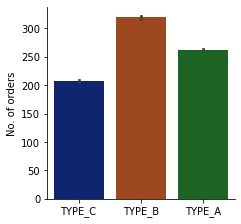

In [32]:
g = sns.catplot(
    data=df_combined, kind="bar",
    x="center_type", y="num_orders",
     palette="dark"
)
g.fig.set_figwidth(3)
g.fig.set_figheight(3)
g.set_axis_labels("", "No. of orders")

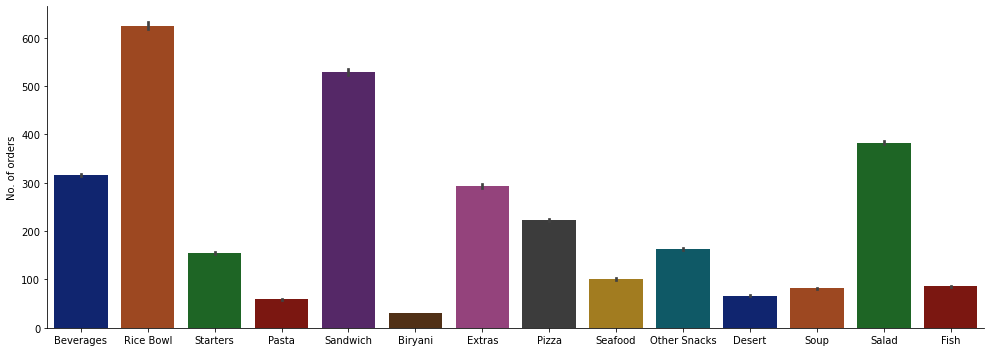

In [33]:
g = sns.catplot(
    data=df_combined, kind="bar",
    x="category", y="num_orders",
     palette="dark"
)
g.fig.set_figwidth(15)
g.fig.set_figheight(5)
g.set_axis_labels("", "No. of orders")

<AxesSubplot:xlabel='week', ylabel='num_orders'>

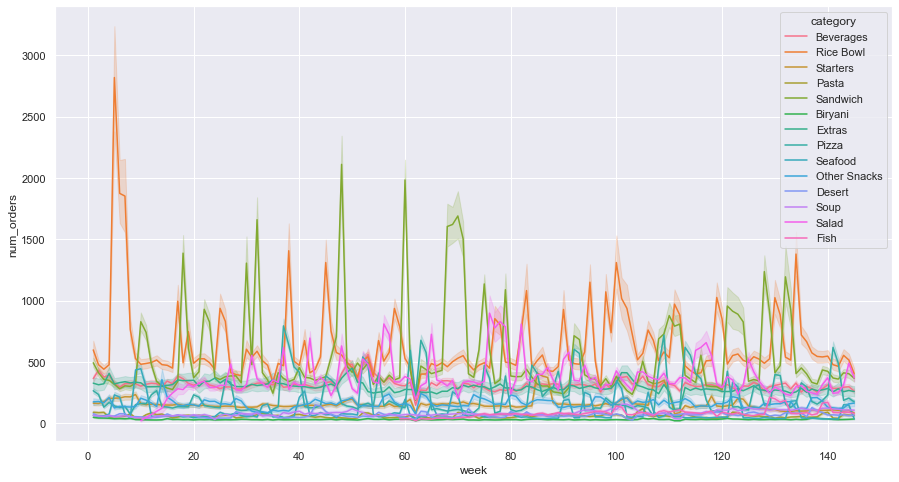

In [36]:
df_select = df_combined[(df_combined['category'] == 'Pasta') | (df_combined['category'] == 'Beverages')]
sns.set(rc={'figure.figsize':(15, 8)})
sns.lineplot(x="week", y="num_orders", data=df_combined, hue="category")

<AxesSubplot:xlabel='week', ylabel='num_orders'>

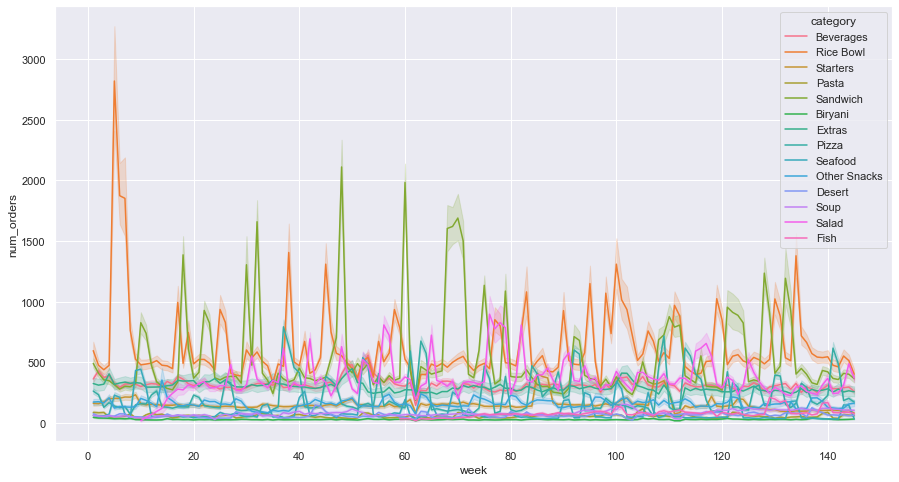

In [34]:
sns.lineplot(x="week", y="num_orders", data=df_combined, hue="category")

<AxesSubplot:xlabel='week', ylabel='num_orders'>

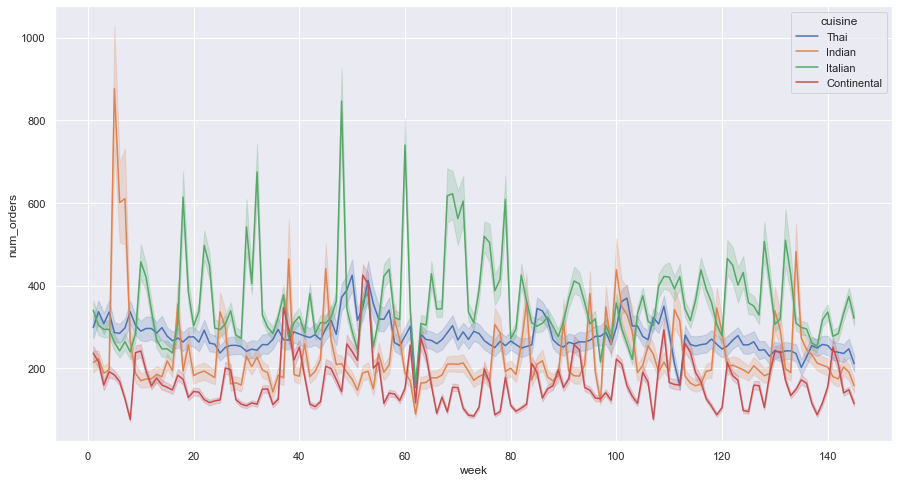

In [35]:
sns.lineplot(x="week", y="num_orders", data=df_combined, hue="cuisine")

### 3.2. Baseline model and its performance using the raw features only

In [27]:
# lets encapsulate some common evaluation logic into a function 
# to be used for experimenting with multiple algorithms, etc. 
def eval_model(model, alg_name, X, y):
    try:
        y_pred = model.predict(X).ravel()
        y = y.ravel()
        print(alg_name)
        print('r^2 = ', skm.r2_score(y, y_pred))
        print('mae = ', skm.mean_absolute_error(y, y_pred))
        print('mse = ', skm.mean_squared_error(y, y_pred))
        print('msle = ', skm.mean_squared_log_error(y, y_pred))
        print('----------------------------------------------')
    except Exception as error:
        plot_results(y, y_pred)
        return y_pred
        print(error)
    plot_results(y, y_pred)
    return y_pred

In [16]:
def plot_results(y_true, y_pred):    
    result_df = pd.DataFrame(np.vstack((y_val, y_pred)).T, 
                                        columns=['Actual', 'Predicted'])
    df = result_df.sample(n=100, replace=True)
    df['No.'] = range(len(df))
    df.plot(x="No.", y=['Actual', 'Predicted'], kind = 'line', legend=True, 
            subplots = False, sharex = True, figsize = (5.5,4), ls="none", 
            marker="o", alpha=0.4)    
    plt.show()

In [20]:
# lets encapsulate some common experiment running logic into a function 
# to allow experimenting with multiple algorithms, etc. 
def run_experiment(X, y) :   
    #we want to keep the sequence in tact so shuffle is set to false
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                      random_state=rand_seed, 
                                                      shuffle=False)
    
    rfr = RandomForestRegressor(random_state=rand_seed, n_estimators=100)
    gbr = GradientBoostingRegressor(random_state=rand_seed)
    xgb = XGBRegressor(random_state=rand_seed)
    
    rfr_fitted = rfr.fit(x_train, y_train.ravel())
    gbr_fitted = gbr.fit(x_train, y_train.ravel())
    xgb_fitted = xgb.fit(x_train, y_train.ravel())
    
    y_pred_rfr = eval_model(rfr_fitted, 'RandomForest', x_val, y_val)
    y_pred_gbr = eval_model(gbr_fitted, 'GradientBoost', x_val, y_val)
    y_pred_xgb = eval_model(xgb_fitted, 'XGBoost', x_val, y_val)
    
    #plot_results(y_val, y_pred_rfr, y_pred_gbr, y_pred_xgb)    
    return y_val, y_pred_rfr, y_pred_gbr, y_pred_xgb

In [21]:
#train_df = train_td_df.to_pandas(all_rows=True)
rand_seed = 111 #999
X = train_df[['center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured']]
y = train_df['num_orders']

if 'id' in train_df.columns:
    train_df.set_index('id', inplace=True)

run_experiment(X, y)

[10:36:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomForest
r^2 =  0.6075679733592367
mae =  109.78609052405841
mse =  52575.63338198661
msle =  0.5255219918851639
----------------------------------------------
GradientBoost
r^2 =  0.5122464336604091
mae =  139.1885866546196
mse =  65346.22799301135
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
XGBoost
r^2 =  0.5126742043317971
mae =  139.94972592796753
mse =  65288.91790498674
Mean Squared Logarithmic Error cannot be used when targets contain negative values.


### 2.3. A better model using simple data wrangling 

In [24]:
# this shows how we can do some data wrangling in-db by calling sql using TDML library
# this sql allows adding additional features by combining information from 
# the meal_info and center_info tables
train_td_df = DataFrame.from_query('''
SELECT a.*, b.category, b.cuisine, c.center_type, c.op_area
FROM demand_forecast_demo_train_raw as a
	LEFT JOIN 
	demand_forecast_demo_meal as b 
	ON 
	a.meal_id = b.meal_id
	LEFT JOIN 
	demand_forecast_demo_center as c 
	ON
	a.center_id = c.center_id;
    ''')
train_td_df.head()

   week  center_id  meal_id  checkout_price  base_price  emailer_for_promotion  homepage_featured  num_orders      category      cuisine center_type  op_area
0     1         43     2707          193.06      194.06                      0                  0        1351     Beverages      Italian      TYPE_A      5.1
1     1        153     2707          193.06      194.06                      0                  0         756     Beverages      Italian      TYPE_A      3.9
2     1         58     2304          504.43      505.43                      0                  0          14        Desert       Indian      TYPE_C      3.8
3     1        106     2539          112.52      112.52                      0                  0         177     Beverages         Thai      TYPE_A      4.0
4     1         50     1247          484.03      484.03                      0                  0          53       Biryani       Indian      TYPE_A      4.8
5     1        109     1525          242.50      282

In [25]:
# Experiment 2: train/evaluate model(s) with additional features
# also encode categorical features using one-hot encoding

rand_seed = 111 #999
## Data Prep
feature_names = ['center_id', 'meal_id', 'checkout_price', 'base_price',
                'emailer_for_promotion', 'homepage_featured','center_type', 
                 'op_area', 'category', 'cuisine']
feature_names_cat = ['center_type', 'category', 'cuisine']
target_name = 'num_orders'

# cast the td dataframe into a pandas dataframe to allow
# using the data with sklearn models/functions
train_df = train_td_df.to_pandas(all_rows = True)

#one hot encode the categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
features_df = pd.DataFrame(encoder.fit_transform(train_df[feature_names_cat]), 
                            columns=encoder.get_feature_names())

# dataframe with encoded features
train_df.drop(columns=feature_names_cat, inplace=True)
train_df_enc = pd.concat((train_df, features_df), axis=1)

# features and target columns 
X = train_df_enc.drop(columns=target_name)
y = train_df_enc[target_name]

y_val, y_pred_rfr, y_pred_gbr, y_pred_xgb = run_experiment(X, y)

[20:49:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomForest
r^2 =  0.7666596121468876
mae =  80.31217325594129
mse =  28329.75747655679
msle =  0.3021762975523236
----------------------------------------------
GradientBoost
r^2 =  0.6337997288100048
mae =  117.28936941703174
mse =  44460.21953641625
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
XGBoost
r^2 =  0.634299773998033
mae =  117.09659999552007
mse =  44399.50926232054
Mean Squared Logarithmic Error cannot be used when targets contain negative values.


TypeError: cannot unpack non-iterable NoneType object

In [14]:
print(train_td_df.shape, train_df.shape, features_df.shape, train_df_enc.shape)

(456548, 12) (456548, 9) (456548, 21) (456548, 30)


In [28]:
y_val, y_pred_rfr, y_pred_gbr, y_pred_xgb = run_experiment(X, y)

[09:10:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomForest
r^2 =  0.7666596121468876
mae =  80.31217325594129
mse =  28329.75747655679
----------------------------------------------
GradientBoost
r^2 =  0.6337997288100048
mae =  117.28936941703174
mse =  44460.21953641625
----------------------------------------------
XGBoost
r^2 =  0.634299773998033
mae =  117.09659999552007
mse =  44399.50926232054
----------------------------------------------


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# we do not have any separate labelled test dataset so we need to build
# train/test tables for demo to be used by AOA using the train set
# and since we want to keep the sequence, instead of sampling we use the fix sizes
n = round(train_td_df.shape[0]*0.8) #80% data for training
copy_to_sql(df = train_td_df.iloc[0:n], table_name = "DEMAND_FORECAST_TRAIN", index=False, if_exists="replace")
copy_to_sql(df = train_td_df.iloc[n:], table_name = "DEMAND_FORECAST_TEST", index=False, if_exists="replace")
#train_td_df.columns